# Chess ML Model

## Import Libraries

In [1]:
import chess.pgn
import chess.engine
import numpy as np
from collections import Counter
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2026-01-17 12:28:19.154132: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-17 12:28:19.791704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-17 12:28:22.030362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Implementation

### Board → Tensor

In [2]:
def board_to_tensor(board: chess.Board) -> np.ndarray:
    """
    Input: chess.Board
    Output: numpy array of shape (8, 8, 17)
    """
    tensor = np.zeros((8, 8, 17), dtype=np.float32)

    # Piece type mapping for python-chess
    piece_map = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }

    # Iterate through all squares
    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece is not None:
            rank = 7 - (square // 8)
            file = square % 8

            piece_type_idx = piece_map[piece.piece_type]

            plane = piece_type_idx
            if piece.color == chess.BLACK:
                plane += 6

            tensor[rank, file, plane] = 1
    
    # Side to move
    tensor[:, :, 12] = 1.0 if board.turn == chess.WHITE else 0.0

    # Planes 13-16: Castling rights
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[:, :, 13] = 1.0
    
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[:, :, 14] = 1.0
    
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[:, :, 15] = 1.0
    
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[:, :, 16] = 1.0

    return tensor

### Score Label

In [3]:
def score_to_label(score, equal_threshold=50):
    """
    Convert centipawn score to label.
    
    Returns:
        0 = Black better
        1 = Equal
        2 = White better
    """
    white_score = score.white()

    if white_score.is_mate():
        return 2 if white_score.mate() > 0 else 0
    
    cp = white_score.score()
    if cp is None:
        return 1  # fallback safety
    
    if cp > equal_threshold:
        return 2
    elif cp < -equal_threshold:
        return 0
    else:
        return 1
        

### Position → Training Sample

In [4]:
def create_dataset_from_pgn(pgn_file, MAX_POSITIONS=200):
    '''
    Create dataset from PGN file.
    Return:
        List of (tensor, label) tuples
    '''
    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
    dataset = []

    SKIP_PLIES = 8
    STRIDE = 3
    ply = 0

    with open(pgn_file, "r", encoding="utf-8") as f:
        while len(dataset) < MAX_POSITIONS:
            game = chess.pgn.read_game(f)
            if game is None:
                break       # Stop as no more games

            board = game.board()
            ply += 1

            if ply < SKIP_PLIES:
                continue

            if ply % STRIDE != 0:
                continue
            
            for move in game.mainline_moves():
                board.push(move)
                
                info = engine.analyse(board, chess.engine.Limit(depth=12))

                if "score" in info:
                    tensor = board_to_tensor(board)
                    label = score_to_label(info["score"])
                    dataset.append((tensor, label))

                if len(dataset) >= MAX_POSITIONS:
                    break

    engine.quit()
    return dataset

## Load PGN File
PGN means Portable Games Notation. On more and more games a PGN files becomes more solid.

In [5]:
pgn_file = "hastm2526.pgn"

dataset = create_dataset_from_pgn(pgn_file, 1000)

print(len(dataset))
print(dataset[0][0].shape)

labels = [label for _, label in dataset]
print(Counter(labels))

1000
(8, 8, 17)
Counter({1: 482, 0: 273, 2: 245})


## Data Preparation

### Convert dataset

In [6]:
X = np.array([tensor for tensor, _ in dataset])
y = np.array([label for _, label in dataset])

print(X.shape)
print(y.shape)

(1000, 8, 8, 17)
(1000,)


### Split dataset

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(800, 8, 8, 17) (800,)
(200, 8, 8, 17) (200,)


### Class Weights

In [8]:
label_counts = Counter(y_train)
print(label_counts)

total = len(y_train)
num_classes = 3

class_weight = {
    cls: total / (num_classes * count)
    for cls, count in label_counts.items()
}

print(class_weight)

Counter({np.int64(1): 386, np.int64(0): 218, np.int64(2): 196})
{np.int64(2): 1.3605442176870748, np.int64(1): 0.690846286701209, np.int64(0): 1.2232415902140672}


## Model

In [9]:
model = models.Sequential([
    layers.Input(shape=(8, 8, 17,)),
    layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

model.summary()

2026-01-17 12:28:51.377558: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,475 (2.13 MB)

 Trainable params: 557,475 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    class_weight=class_weight,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30


/home/biraj/miniconda3/lib/python3.13/site-packages/keras/src/backend/tensorflow/nn.py:1214: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5512 - loss: 0.9095 - val_accuracy: 0.7050 - val_loss: 0.6226
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7663 - loss: 0.5141 - val_accuracy: 0.7700 - val_loss: 0.5574
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8487 - loss: 0.3782 - val_accuracy: 0.7800 - val_loss: 0.5613
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8662 - loss: 0.3137 - val_accuracy: 0.8000 - val_loss: 0.5078
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8850 - loss: 0.2679 - val_accuracy: 0.8100 - val_loss: 0.4444
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8900 - loss: 0.2424 - val_accuracy: 0.7900 - val_loss: 0.5625
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9038 - loss: 0.2079 - val_accuracy: 0.7850 - val_loss: 0.5593
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9275 - loss: 0.1658 - val_accuracy: 0.7950 - val_loss: 0.5241
Ep

## Test

In [11]:
# Predict on training data (for now)
y_val_pred = np.argmax(model.predict(X_val), axis=1)

print("Predicted labels:", y_val_pred[:10])
print("True labels     :", y_val[:10])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Predicted labels: [1 1 1 2 2 1 1 1 2 1]
True labels     : [2 1 2 2 2 1 1 1 2 2]


## Confusion Matrix

In [12]:
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)

[[37 17  1]
 [ 6 75 15]
 [ 1  9 39]]


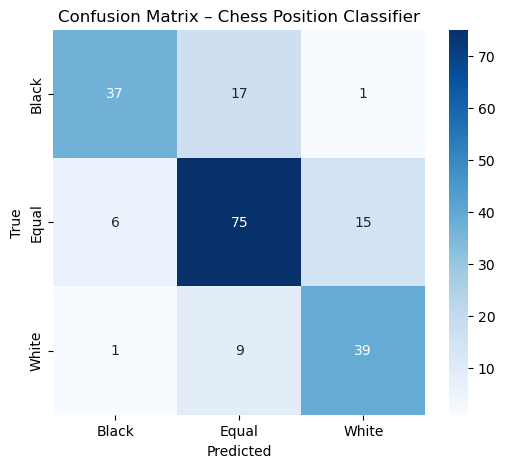

In [13]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Black", "Equal", "White"],
    yticklabels=["Black", "Equal", "White"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Chess Position Classifier")
plt.show()

## Save the Model

In [14]:
model.save("models/chess_cnn_evaluator.keras")